In [1]:
import torch
from torch.utils.data import DataLoader
from livelossplot import PlotLosses
from tqdm.notebook import tqdm

import sys; sys.path.append("src/")
from models import AutoregTheoryModel, AutoregGPT2Model
from my_datasets import AutoregDataset, AutoregCustomTokensDataset
from train_utils import init_optimizer_and_lr_scheduler

In [2]:
# Various directory and device info
saveto_dir = "_saved_models"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def train_model(model, dataloader, optimizer, lr_scheduler, tick=10):
    plot = PlotLosses()
    model.train().to(device)
    all_losses, all_elems_accs, all_state_accs = [], [], []
    pbar = tqdm(dataloader)
    for i, batch in enumerate(pbar):
        tokens, labels = batch["tokens"].to(device), batch["labels"].to(device)
        out = model(tokens, labels=labels)
        loss = out.loss
        loss.backward();
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step(); lr_scheduler.step(); optimizer.zero_grad()

        # Track stuff
        pred = (out.logits > 0).long()
        loss = loss.detach().cpu().item()
        elems_acc = (pred == labels).float().mean().cpu().item()
        state_acc = (pred == labels).all(dim=-1).all(dim=-1).float().mean().cpu().item()
        # state_acc = (pred == labels).all(dim=-1).float().mean().cpu().item()
        all_losses.append(loss); all_elems_accs.append(elems_acc); all_state_accs.append(state_acc)

        plot.update({"loss": loss, "acc_elems": elems_acc, "acc_state": state_acc})
        
        if (i+1) % tick == 0:
            plot.send()

    return {
        "model": model,
        "losses": all_losses,
        "elems_accs": all_elems_accs,
        "state_accs": all_state_accs,
    }

In [4]:
def init_and_train(model, num_props, batch_size, num_optim_steps, lr):
    dataset = AutoregDataset(num_props, batch_size*num_optim_steps)
    dataloader = DataLoader(dataset, batch_size)
    optimizer, lr_scheduler = init_optimizer_and_lr_scheduler(model, num_optim_steps, lr)
    ret = train_model(model, dataloader, optimizer, lr_scheduler)
    return ret

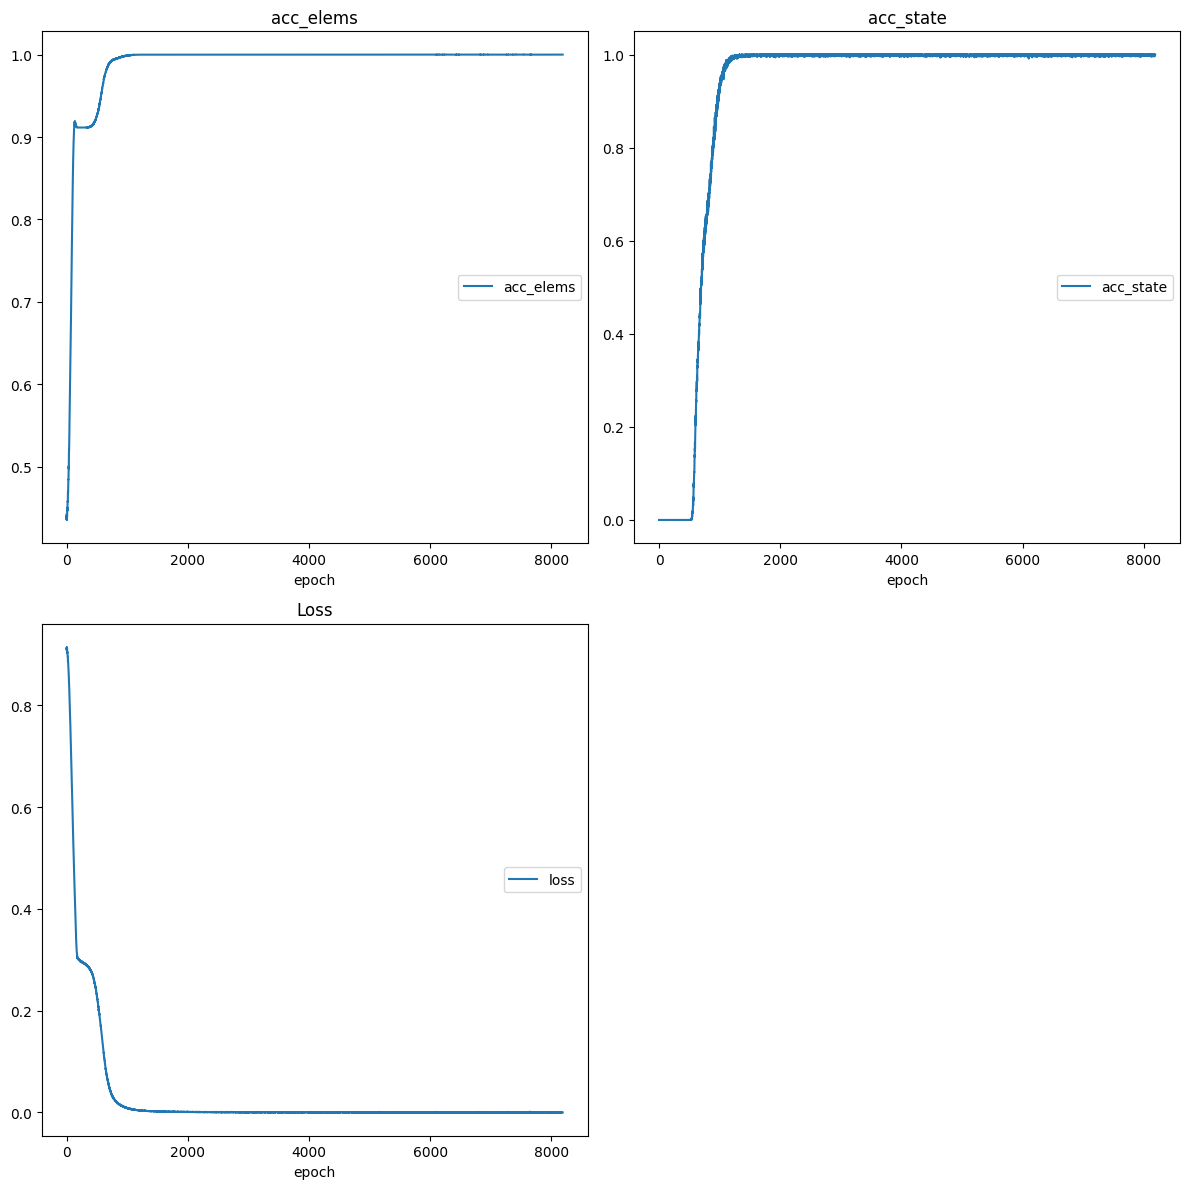

acc_elems
	acc_elems        	 (min:    0.435, max:    1.000, cur:    1.000)
acc_state
	acc_state        	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	loss             	 (min:    0.000, max:    0.914, cur:    0.000)


In [5]:
def call_to_train_custom():
    num_autoreg_steps = 3
    batch_size = 512
    num_optim_steps = 8192
    lr = 5e-4
    for num_props in [16, 32, 48, 64]:
        # for do_ln in [False, True]:
        for do_ln in [False]:
            ln_str = "1" if do_ln else "0"
            saveto = f"theory_n{num_props}_ln{ln_str}_ar{num_autoreg_steps}_bsz{batch_size}_ns{num_optim_steps}_lr{lr:.4f}.pt"
            print(f"Running: {saveto}")
            ret = init_and_train(
                model = AutoregTheoryModel(num_props, num_autoreg_steps, do_layer_norm=do_ln),
                num_props = num_props,
                batch_size = batch_size,
                num_optim_steps = num_optim_steps,
                lr = lr
            )
            ret["model"] = ret["model"].eval().cpu().state_dict()
            torch.save(ret, saveto_dir + "/" + saveto)

# call_to_train_custom() # Uncomment to train

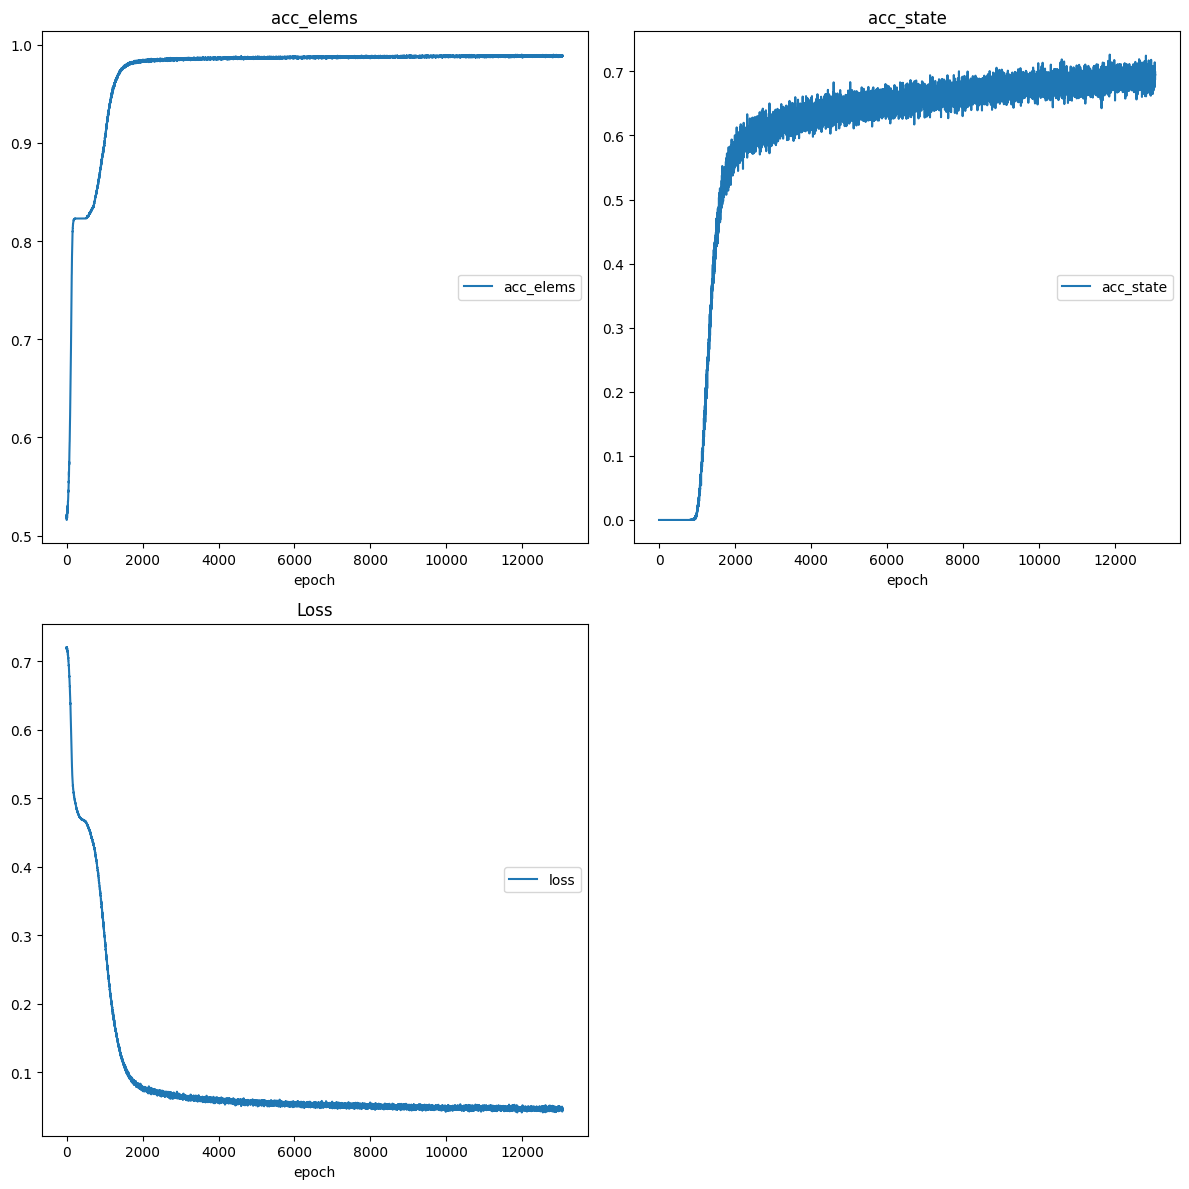

acc_elems
	acc_elems        	 (min:    0.516, max:    0.990, cur:    0.989)
acc_state
	acc_state        	 (min:    0.000, max:    0.726, cur:    0.699)
Loss
	loss             	 (min:    0.041, max:    0.721, cur:    0.046)


In [ ]:
def call_to_train_gpt2():
    num_autoreg_steps = 3
    batch_size = 1024
    num_optim_steps = 16384
    lr = 5e-4
    for num_props in [32, 64]:
        saveto = f"gpt2s_n{num_props}_ar{num_autoreg_steps}_bsz{batch_size}_ns{num_optim_steps}_lr{lr:.4f}.pt"
        print(f"Running: {saveto}")
        ret = init_and_train(
            model = AutoregGPT2Model(num_props, num_autoreg_steps),
            num_props = num_props,
            batch_size = batch_size,
            num_optim_steps = num_optim_steps,
            lr = lr
        )
        ret["model"] = ret["model"].eval().cpu().state_dict()
        torch.save(ret, saveto_dir + "/" + saveto)

# call_to_train_gpt2() # Uncomment to train

In [ ]:
# Plot stuff
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(8,4))

for num_props in [16, 32, 48, 64]:
    for do_layer_norm in [False, True]:
        ln_str = "1" if do_layer_norm else "0"
        saveto = f"theory_n{num_props}_ln{ln_str}_ar{num_autoreg_steps}_bsz{batch_size}_ns{num_optim_steps}_lr{lr:.4f}.pt"
        save_dict = torch.load(saveto_dir + "/" + saveto)
        # try to load the model state dict just to make sure
        model = AutoregTheoryModel(num_props, 3, do_layer_norm=do_layer_norm)
        model.load_state_dict(save_dict["model"])
        label = f"n{num_props}_ln{ln_str}"
        ax[0].plot(np.array(save_dict["losses"]), label=label)
        ax[1].plot(np.array(save_dict["state_accs"]), label=label)

ax[0].legend(loc="upper right", title="Custom Train Loss")
ax[1].legend(loc="lower right", title="Custo mState Accs")

In [ ]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(8,4))

for num_props in [16, 32, 48, 64]:
    saveto = f"gpt2s_n{num_props}_ar{num_autoreg_steps}_bsz{batch_size}_ns{num_optim_steps}_lr{lr:.4f}.pt"
    save_dict = torch.load(saveto_dir + "/" + saveto)
    # try to load the model state dict just to make sure
    model = AutoregGPT2Model(num_props, 3)
    model.load_state_dict(save_dict["model"])
    label = f"n{num_props}_ln{ln_str}"
    ax[0].plot(np.array(save_dict["losses"]), label=label)
    ax[1].plot(np.array(save_dict["state_accs"]), label=label)

ax[0].legend(loc="upper right", title="GPT-2 Train Loss")
ax[1].legend(loc="lower right", title="GPT-2 State Accs")